# CR tomography

$\newcommand{\bra}[1]{\langle #1 |}$
$\newcommand{\ket}[1]{| #1 \rangle}$

Extract IX, IY, IZ, ZX, ZY, ZZ components of the CR drive

- Run a GaussianSquare cross resonance
  - Rabi frequency depends on the drive strength nonlinearly
  - -> Sweep over the pulse area ($|A|(w + \sqrt{2\pi} \sigma \mathrm{erf}(n_{\sigma}))$)
- Start with the control in $\ket{0}$ and $\ket{1}$
- Measure $|\bra{W_0}U_{CR}(t)\ket{W_0}|^2$ for $W = X, Y, Z$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

from qiskit import pulse, QuantumCircuit, transpile, IBMQ
from qiskit.circuit import Gate
from qiskit import schedule as build_schedule
from qiskit.circuit import Parameter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import IQXDebugging

from pulse_experiment_utils import *

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
#backend = provider.get_backend('ibm_kawasaki')
backend = provider.get_backend('ibmq_montreal')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt
calibrations = backend_defaults.instruction_schedule_map

In [3]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
control_qubit = 0
target_qubit = 1

## First, see if inverse Gaussian echo cancels the original

In [4]:
num_rabi_points = 50
drive_amp = Parameter('drive_amp')
sigma = 40
drive_duration = 4 * sigma

drive_amps = np.linspace(0., 0.75, num_rabi_points)

drive_channel = backend_config.drive(target_qubit)

with pulse.build(backend=backend, name='Gaus') as gaus_sched:
    pulse.set_frequency(backend_defaults.qubit_freq_est[target_qubit], drive_channel)
    pulse.play(pulse.Gaussian(duration=drive_duration, amp=drive_amp, sigma=sigma), drive_channel)

with pulse.build(backend=backend, name='SXGausCancel') as gaus_cancel_sched:
    pulse.set_frequency(backend_defaults.qubit_freq_est[target_qubit], drive_channel)
    pulse.play(pulse.Gaussian(duration=drive_duration, amp=drive_amp, sigma=sigma), drive_channel)
    pulse.play(pulse.Gaussian(duration=drive_duration, amp=-drive_amp, sigma=sigma), drive_channel)

experiments = []
for sched in [gaus_sched, gaus_cancel_sched]:
    for axis in ['x', 'y', 'z']:
        experiments += [projection(axis, sched, backend, drive_channel, target_qubit, value_dict={drive_amp: amp}) for amp in drive_amps]

((0, SetFrequency(4834685306.211454, DriveChannel(1))),
 (0,
  Play(Gaussian(duration=160, amp=(0.260204081632653+0j), sigma=40), DriveChannel(1))),
 (160, Acquire(13440, AcquireChannel(1), MemorySlot(0))),
 (160,
  Play(GaussianSquare(duration=13440, amp=(-0.023856784874117083+0.03815565247076897j), sigma=64, width=13184, name='M_m1'), MeasureChannel(1), name='M_m1')))


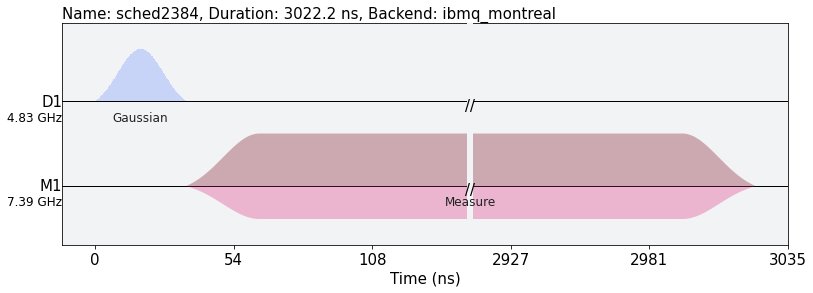

In [5]:
pprint.pprint(experiments[117].instructions)
experiments[117].draw(backend=backend)

result = submit_schedules(experiments, backend)

start = 0
for exp_name in ['Gaus', 'GausCancel']:
    for proj in ['X', 'Y', 'Z']:
        plot_result(result, 0, x=drive_amps, indices=np.arange(start, start + num_rabi_points), title='{}_{}'.format(exp_name, proj), ylim=(-4.0e7, 4.0e7))
        start += num_rabi_points

## Does the cancellation happen in the CR channel too?

In [6]:
num_rabi_points = 50
drive_amp = Parameter('drive_amp')

drive_amps = np.linspace(0., 1., num_rabi_points)

control_channel = backend_config.control(qubits=(control_qubit, target_qubit))[0]

with pulse.build(backend=backend, name='Gaus') as cr_sched:
    pulse.set_frequency(backend_defaults.qubit_freq_est[target_qubit], control_channel)
    pulse.play(pulse.GaussianSquare(duration=704, amp=drive_amp, sigma=64, width=448), control_channel)

with pulse.build(backend=backend, name='SXGausCancel') as cr_cancel_sched:
    pulse.set_frequency(backend_defaults.qubit_freq_est[target_qubit], control_channel)
    pulse.play(pulse.GaussianSquare(duration=704, amp=drive_amp, sigma=64, width=448), control_channel)
    pulse.play(pulse.GaussianSquare(duration=704, amp=-drive_amp, sigma=64, width=448), control_channel)

experiments = []
for sched in [cr_sched, cr_cancel_sched]:
    for axis in ['x', 'y', 'z']:
        experiments += [projection(axis, sched, backend, control_channel, target_qubit, value_dict={drive_amp: amp}) for amp in drive_amps]

((0, SetFrequency(4834685306.211454, DriveChannel(1))),
 (0, ShiftPhase(-1.5707963267948966, DriveChannel(1))),
 (0,
  Play(Drag(duration=160, amp=(0.09599362514963176+0.0007219297872998672j), sigma=40, beta=0.35358821345636215, name='X90p_d1'), DriveChannel(1), name='X90p_d1')),
 (160, ShiftPhase(-1.5707963267948966, DriveChannel(1))),
 (160, SetFrequency(4834685306.211454, ControlChannel(0))),
 (160,
  Play(GaussianSquare(duration=704, amp=(0.346938775510204+0j), sigma=64, width=448), ControlChannel(0))),
 (864,
  Play(GaussianSquare(duration=704, amp=(-0.346938775510204+0j), sigma=64, width=448), ControlChannel(0))),
 (1568, ShiftPhase(-1.5707963267948966, DriveChannel(1))),
 (1568,
  Play(Drag(duration=160, amp=(0.09599362514963176+0.0007219297872998672j), sigma=40, beta=0.35358821345636215, name='X90p_d1'), DriveChannel(1), name='X90p_d1')),
 (1728, ShiftPhase(-1.5707963267948966, DriveChannel(1))),
 (1728, Acquire(13440, AcquireChannel(1), MemorySlot(0))),
 (1728,
  Play(Gaussian

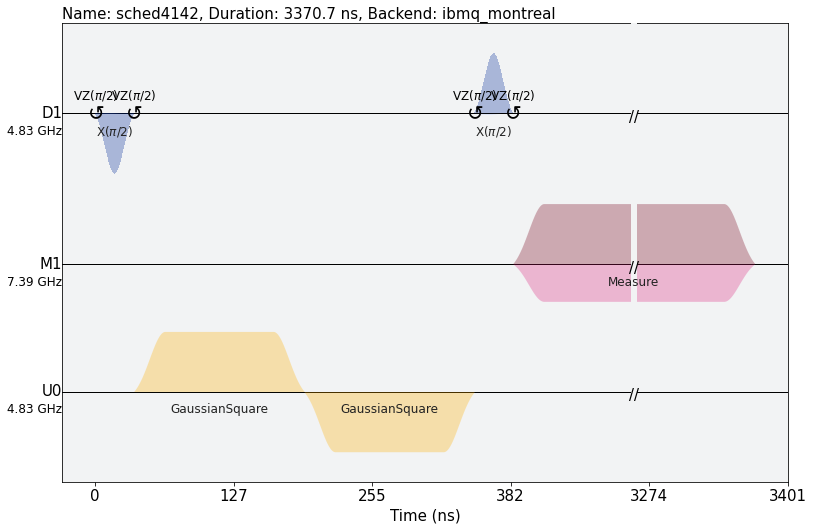

In [7]:
pprint.pprint(experiments[167].instructions)
experiments[167].draw(backend=backend)

result = submit_schedules(experiments, backend)

start = 0
for exp_name in ['CR', 'CRCancel']:
    for proj in ['X', 'Y', 'Z']:
        plot_result(result, 0, x=drive_amps, indices=np.arange(start, start + num_rabi_points), title='{}_{}'.format(exp_name, proj), ylim=(-4.0e7, 4.0e7))
        start += num_rabi_points

## OK so now we cancel the Gaussian part of the GaussianSquare and scan over the width

In [11]:
sigma = 64
amp = 0.8
gs_widths = np.arange(0, 6464, 128, dtype=int)

schedules = []
for gs_width in gs_widths:
    with pulse.build(backend=backend, name='CR') as sched:
        pulse.set_frequency(backend_defaults.qubit_freq_est[target_qubit], control_channel)
        pulse.play(pulse.GaussianSquare(duration=(gs_width + 4 * sigma), amp=amp, sigma=sigma, width=gs_width), control_channel)
        pulse.play(pulse.Gaussian(duration=(4 * sigma), amp=-amp, sigma=sigma), control_channel)

    schedules.append(sched)

experiments = []
for axis in ['x', 'y', 'z']:
    experiments += [projection(axis, sched, backend, target_qubit, exclude=(lambda inst: type(inst[1]) is pulse.Delay)) for sched in schedules]

((0, SetFrequency(4834685306.211454, DriveChannel(1))),
 (0,
  Play(Drag(duration=160, amp=(0.09599362514963176+0.0007219297872998672j), sigma=40, beta=0.35358821345636215, name='X90p_d1'), DriveChannel(1), name='X90p_d1')),
 (160,
  Play(Drag(duration=160, amp=(0.1923725063880124+0j), sigma=40, beta=0.28823357271458344, name='Xp_d1'), DriveChannel(1), name='Xp_d1')),
 (320, SetFrequency(4834685306.211454, ControlChannel(0))),
 (320,
  Play(GaussianSquare(duration=6656, amp=(0.8+0j), sigma=64, width=6400), ControlChannel(0))),
 (6976,
  Play(Gaussian(duration=256, amp=(-0.8+0j), sigma=64), ControlChannel(0))),
 (7232,
  Play(Drag(duration=160, amp=(0.1923725063880124+0j), sigma=40, beta=0.28823357271458344, name='Xp_d1'), DriveChannel(1), name='Xp_d1')),
 (7392,
  Play(Drag(duration=160, amp=(0.09599362514963176+0.0007219297872998672j), sigma=40, beta=0.35358821345636215, name='X90p_d1'), DriveChannel(1), name='X90p_d1')),
 (7552, Acquire(13440, AcquireChannel(1), MemorySlot(0))),
 (75

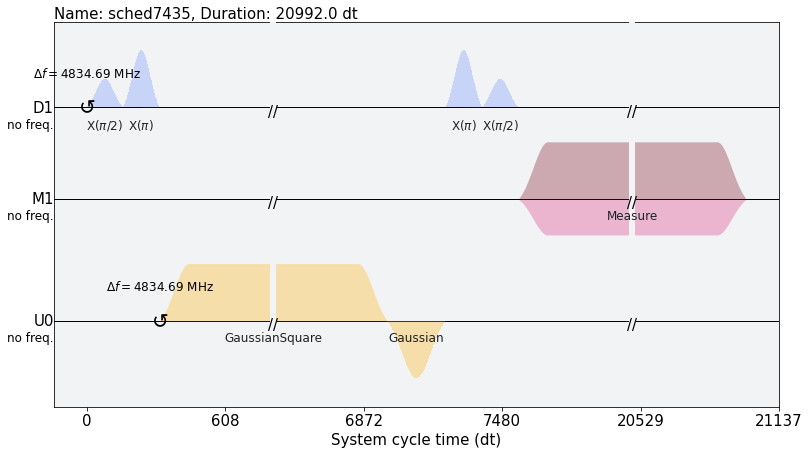

In [13]:
pprint.pprint(experiments[101].instructions)
experiments[101].draw()

/usr/local/lib/python3.8/dist-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run


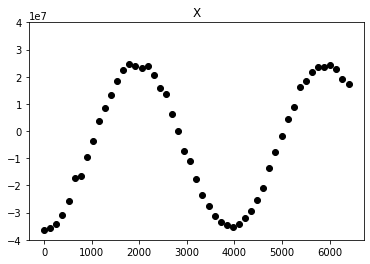

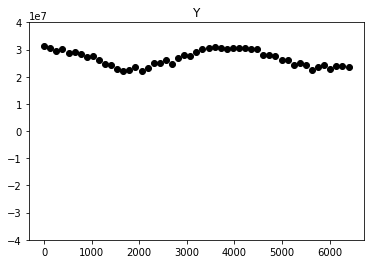

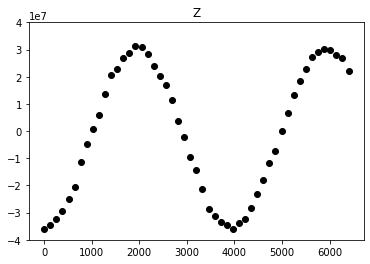

In [14]:
result = submit_schedules(experiments, backend)

start = 0
for proj in ['X', 'Y', 'Z']:
    plot_result(result, 0, x=gs_widths, indices=np.arange(start, start + gs_widths.shape[0]), title=proj, ylim=(-4.0e7, 4.0e7))
    start += gs_widths.shape[0]

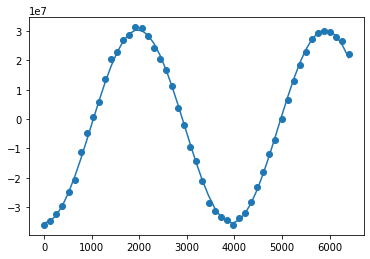

In [22]:
from scipy.optimize import curve_fit

y_values = np.array([result.get_memory(int(iw))[0].real for iw in np.arange(2 * gs_widths.shape[0], 3 * gs_widths.shape[0])])
init_params = [2. * np.pi / 4000., 3.0e7, 1.0e6]
fitparams, conv = curve_fit(lambda w, v, amp, offset: offset + amp * np.cos(w * v), gs_widths, y_values, init_params)

plt.scatter(gs_widths, y_values)
plt.plot(gs_widths, fitparams[2] + fitparams[1] * np.cos(fitparams[0] * gs_widths))
plt.show()

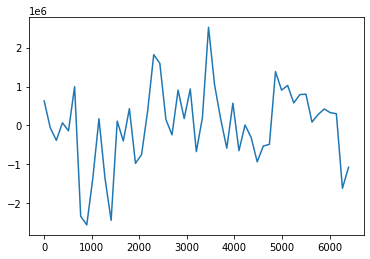

In [23]:
plt.plot(gs_widths, fitparams[2] + fitparams[1] * np.cos(fitparams[0] * gs_widths) - y_values)